# Module 6: How to create and communicate data queries

In this module you learned about the challenges of translating clinical questions into data queries and the importance of clarity and rigour in doing do. The outcomes of this module are as follows:

1. **Translate clinical questions** into data queries and requirements, and evaluate the suitability of a healthcare dataset for addressing a specific research question, considering the quality and structure of the data
2. **Understand and apply commonly used healthcare terminologies** - including geographic and clinical coding standards - to interpret and work effectively with Australian healthcare data
3. Perform essential **data cleaning transformations**, and **data quality assessments** to prepare clinical datasets for analysis and research
4. Identify and address **commmon data quality issues**, evaluating their impact on the feasibility of a research question

This notebook consists of four activities, which build on and test what you have learned in the pre-class material

## Datasets

We will work with two different datasets in this activity, so that you can gain experience with common data sources that appear in Australian healthcare settings:

- [Australian Institute of Health and Welfare (AIHW)) cancer incidence in Australia](https://www.aihw.gov.au/reports/cancer/cancer-data-in-australia/contents/overview) by age group and 4 digit ICD-10 code
- [Australian Bureau of Statistics Census Data](https://www.abs.gov.au/census)

## Activity 1: Carry out a basic data quality assessment of a healthcare dataset

The paper describing the Kahn Data Quality Framework can be found here: https://pmc.ncbi.nlm.nih.gov/articles/PMC5051581/

In this activity you will summarise important information about the quality of the data across the two of the three main dimensions in Kahn's Data Quality Framework, namely:
- Completeness
- Conformance

## Activity 2: Translate a healthcare question into a data query

Following the initial brief data quality assessment, we can now look at a particularly topical question in public health related to the incidence of colorectal cancer among young people. You will translate this into a data query so that in the next step you can carry out a set of clearly defined transformations and data cleaning operations.

## Activity 3: Carry out data wrangling and cleaning transformations on a clinical dataset

Now you will do the work with the data necessary to address the query. You will make use of what you have learned in the modules about data transformations and data cleaning in order to arrive at your results

## Activity 4: Translate the results back into language that addresses the question

Finally we need to provide a concise response that addresses the initial query. In this final activity you will do this, outlining any assumptions, caveats and limitations as well.

## Configure the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

from easypandas import EasyDataFrame, clean_numeric_string

sns.set()
%matplotlib inline

## Load the data

Run the code cell below to load the dataset

In [2]:
df = (
    EasyDataFrame(pd.read_csv('cancer_stats_aihw_new.csv'))
    .loc[:, ['data_typer', 'year', 'sex', 'age_group', 'num_cases', 'age_rate_std_2024', 'icd10_subsite']]
)

## Activity 1: Data quality assessment

In any sort of data analysis, the first step is to understand the data itself, including any data quality issues that may impact downstream analyses. We begin by inspecting the dataset that we use later on, to identify what some of these issues are.

But what do we mean by data quality? One way of thinking about data quality is through the [Kahn Data Quality Framework](https://pmc.ncbi.nlm.nih.gov/articles/PMC5051581/). This framework defines data quality across different categories: 
- conformance
- completeness
- plausibility

We will look at the first two.

The dataset we are working with is actually quite good quality, with relatively few issues, as it is from an official government agency. 

### 1.1. Conformance

"Conformance focuses on DQ features that describe the compliance of the representation of data against internal or external formatting, relational, or computational definitions. "

- Value conformance: agree with specified standards
- Relational conformance: satisfy logical relations specified by a database
- Computational conformance: derived values fit a standard

**Task: Inspect the dataset and identify ways in which the different columns do or do not conform to the format that you would expect. For example: numbers may be represented as text, time values may include decimal points.**

In your response below focus on the columns:
- year
- sex
- age group
- num_cases
- age_rate_std_2024
- icd10_subsite


In [3]:
# run this code to look at a random subset of 5 rows of the table
df.filter('data_typer', 'equals', "Actual").sample(5, random_state=42)

,data_typer,year,sex,age_group,num_cases,age_rate_std_2024,icd10_subsite
11652,Actual,2004.0,Females,25–34,5.0,0.3,Please refer to Cancer commentary number 7 for...
78852,Actual,2005.0,Persons,25–34,0.0,0.0,C63
44611,Actual,1990.0,Males,15–24,1.0,0.1,C22
115184,Actual,1999.0,Persons,45–54,235.0,9.3,C54–C55
73888,Actual,2017.0,Persons,85+,14.0,2.9,"C92.2, C92.9, C93.2, C93.7, C93.9, C94.6"


Enter your responses below

In [4]:
# year: decimal rather than integer
# sex: ok
# age group: age bands may not be suitable  
# num_cases: decimal rather than integer
# age_rate_std_2024: ok
# icd10_subsite: has free text, individual cases, spans and lists

### 1.2. Completeness

*Completeness* measures how many of the responses are filled in. Usually we calculate its opposite, *missingness*, i.e., many values are missing in each column.

**Task: Run the code in the cells below to calculate proportion of values that are complete, i.e., not missing, for each column**

Hint: Sometimes missing values are recorded as `NaN` or `null` but there may just be values that can't be recognised as a value.

In [5]:
# number of missing values in year
df.select('year').isnull().sum().item()

0

In [6]:
# number of missing values for sex
df.select('sex').isnull().sum().item()

0

In [7]:
# number of missing values for age group
df.select('age_group').isnull().sum().item()

0

In [8]:
# number of missing values for cases
df.select('num_cases').isnull().sum().item()

0

In [9]:
# number of missing values for age_rate_std_2024
pd.to_numeric(df.select('age_rate_std_2024'), errors='coerce').isnull().mean()

np.float64(0.0)

In [10]:
# number of missing values for icd10_subsite
df.icd10_subsite.isnull().sum()

np.int64(0)

Enter you responses below

In [11]:
# year: 100% complete
# sex: 100% complete
# age_group: 100% complete
# age_rate_std_2024: 100% complete
# icd10_subsite: 100% complete

## Activity 2: Translate a public health question into a data query

It has been observed in many countries that [diagnoses of colorectal cancers are increasing among younger people](https://pmc.ncbi.nlm.nih.gov/articles/PMC10589420/) while decreasing among other demographics. It is not known what is causing this increase.

Policymakers and public health researchers need to be able to precisely track the numbers of different types of cancers, so they can understand what the overall disease burden is from cancer, and where they might intervene to improve cancer outcomes.

In this first question you will use the AIHW dataset you have just been working to quantify the increase in colorectal cancer cases among younger Australians.


### 2.1. Colorectal cancer incidence among younger people in Australia

<div style="
    border: 2px solid black; 
    border-radius: 10px; 
    padding: 20px; 
    text-align: center; 
    width: 80%; 
    margin: auto; 
    font-family: Arial, sans-serif; 
    font-size: 18px; 
    line-height: 1.5;">
    <strong>Suppose a policymaker asks you the following question:</strong><br><br>
    <em>How is the incidence of young onset colorectal cancer in Australia changing over time?</em>
</div>


**Task: What are some questions that you need to answer and aspects of the data you need to understand to be able to correctly address this question? Record these in your worksheet**

Enter your responses below

In [12]:
# define 'young onset' age groups
# which icd10 codes are relevant to colorectal cancer?
# what is meant by incidence?
# what time period are they interested in?

### 2.2. Inspecting the data

Let's begin by taking a peek at the data. Run the following code cell

In [13]:
df.sample(5, random_state=42)

,data_typer,year,sex,age_group,num_cases,age_rate_std_2024,icd10_subsite
3137,Projections,2021.0,Females,75–84,1898.0,265.5,"C81–C96, D45, D46, D47.1, D47.3–D47.5"
84841,Actual,2000.0,Males,15–24,0.0,0.0,C08.8–C08.9
5061,Actual,1999.0,Persons,15–24,67.0,2.6,Please refer to Cancer commentary number 7 for...
97953,Actual,2007.0,Males,35–44,1.0,0.1,C65
32404,Actual,2013.0,Males,45–54,461.0,30.3,"C01–C14, C30–C32"


**Task: Fill in what each of the columns means along with the data type. Use your responses from the previous activity to help you.**

In [14]:
# datatype_r: categorical / string, actual numbers vs projected values from a model
# year: year of diagnosis of cancer
# sex: sex of the people diagnosed with the cancer type in the year
# age_group: age group of patient
# num_cases: number of people diagnosed with the given cancer type in the year, age group and sex
# age_rate_std_2024: age standardised rate of cancer, adjusted to age distribution for 2024
# icd10_subsite: location of the primary tumour

### 2.3. Age groups 

Notice that tha age group column reports ages in 10 year increments. In this context *young* is often defined as someone under 50, so these age brackets do not neatly align with this definition. As a result we can use either <45 or <55. We will use under 55 to define young. 

**Run the following code cell**

In [15]:
age_groups_young= ['00–14', '15–24', '25–34', '35–44', '45–54']
age_groups_old = ['75-84', '85+']

age_groups_all = ['00–14', '15–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75–84', '85+']

### 2.4. ICD-10 codes

The ICD10_subsite field specifies the anatomical location where the primary cancer diagnosis was made. So we need to know which codes relate to colorectal cancer. It is best to use an official source such as a publication or from an official cancer agency. The Victorian Cancer Registry defines colorectal cancer (also referred to as bowel cancer) here: https://www.cancervic.org.au/downloads/cec/cancer-in-vic/Cancer%20in%20Victoria%202023.pdf

**What are the ICD10 codes that relate to colorectal cancer? Complete these in the cell below (in the form 'C(number)')**

In [16]:
icd_crc = ['C18', 'C19', 'C20']

In [17]:
# we will compare rates of colorectal cancer with lung cancer
icd_lung = 'C33–C34'

### 2.5. Time periods

What time periods are available in our data? We can quickly inspect the data to see. 

**Run the following code cells**

In [18]:
df.select('year').min()

np.float64(1982.0)

In [19]:
df.select('year').max()

np.float64(2024.0)

## Activity 3: Carry out data cleaning and transformations

### 3.1. Data cleaning

After inspecting the data there are a few issues

1) The num_cases values are considered to be 'strings' because some values contain characters such as ','
2) The year is a decimal rather than an integer
3) There are a mix of projections and actual numbers
4) The icd10_subsite field contains individual ICD10 codes along with some ranges
5) The age_group is a string with off decade definitions of ages

We will carry out some initial transformations to deal with the first two issues, then some transformations to calculate the number of colorectal cancer cancers.

**Run the following code cell**

In [20]:
# some data cleaning to deal with the fact that the num_cases is represented as a string rather than a float
df_cleaner = (
    df
    .add_derived_column('year', 'year', int)
)

The following code carries out a sequence of transformations to calculate the number of CRC cases by year and sex.

**Explain what each of the transformations (each line of code starting with `.`) is doing. Five random rows of the dataframe shown below should help**

In [21]:
df_cleaner.sample(5, random_state=42)

,data_typer,year,sex,age_group,num_cases,age_rate_std_2024,icd10_subsite
3137,Projections,2021,Females,75–84,1898.0,265.5,"C81–C96, D45, D46, D47.1, D47.3–D47.5"
84841,Actual,2000,Males,15–24,0.0,0.0,C08.8–C08.9
5061,Actual,1999,Persons,15–24,67.0,2.6,Please refer to Cancer commentary number 7 for...
97953,Actual,2007,Males,35–44,1.0,0.1,C65
32404,Actual,2013,Males,45–54,461.0,30.3,"C01–C14, C30–C32"


In [22]:
df_crc_young = (
    df_cleaner
    .filter('data_typer', 'equals', 'Actual')
    .filter('icd10_subsite', 'in', icd_crc)
    .filter('age_group', 'in', age_groups_young)
    .groupby(['year', 'sex'], 'num_cases', 'sum')
    .add_column('cancer_type', 'crc')
    .add_column('cohort', 'young')
)

In [23]:
# see what the transformed data looks like
df_crc_young

,year,sex,num_cases,cancer_type,cohort
0,1982,Females,578.0,crc,young
1,1982,Males,583.0,crc,young
2,1982,Persons,1161.0,crc,young
3,1983,Females,569.0,crc,young
4,1983,Males,635.0,crc,young
...,...,...,...,...,...
112,2019,Males,1409.0,crc,young
113,2019,Persons,2727.0,crc,young
114,2020,Females,1260.0,crc,young
115,2020,Males,1432.0,crc,young


**Now write the code to compute these values for older people with colorectal cancer and older and younger people with lung cancer**

In [26]:
df_crc_old = (
    df_cleaner
    .filter('data_typer', 'equals', 'Actual')
    .filter('icd10_subsite', 'in', icd_crc)
    .filter('age_group', 'in', age_groups_old)
    .groupby(['year', 'sex'], 'num_cases', 'sum')
    .add_column('cancer_type', 'crc')
    .add_column('cohort', 'old'))

df_lung_young = (
    df_cleaner
    .filter('data_typer', 'equals', 'Actual')
    .filter('icd10_subsite', 'equals', icd_lung)
    .filter('age_group', 'in', age_groups_young)
    .groupby(['year', 'sex'], 'num_cases', 'sum')
    .add_column('cancer_type', 'lung')
    .add_column('cohort', 'young')
)

df_lung_old = (
    df_cleaner
    .filter('data_typer', 'equals', 'Actual')
    .filter('icd10_subsite', 'equals', icd_lung)
    .filter('age_group', 'in', age_groups_old)
    .groupby(['year', 'sex'], 'num_cases', 'sum')
    .add_column('cancer_type', 'lung')
    .add_column('cohort', 'old')
)

# combine all the results
df_results = pd.concat([df_crc_young, df_crc_old, df_lung_young, df_lung_old])

### 3.2. Plot the results

We will discuss descriptive statistics and visualisation in a later module. For now, you can run the code in the following two code blocks to see a plot of how the number of cases is changing over time.

**Run the following code cell. What do you notice about the graphs for colorectal and lung cancers for young and older people?**

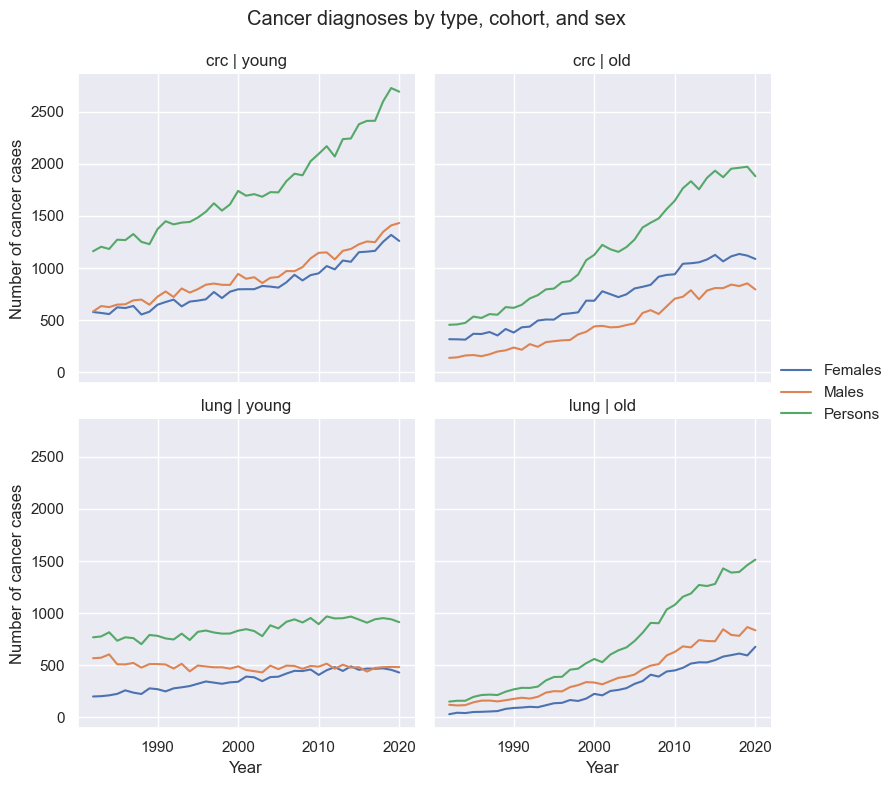

In [27]:
# Create facet grid with cohort as columns, cancer_type as rows
g = sns.FacetGrid(
    df_results,
    row="cancer_type",   # separate row for each cancer type
    col="cohort",        # separate column for each cohort
    height=4,
    aspect=1
)

# Map the lineplots
g.map_dataframe(sns.lineplot, x="year", y="num_cases", hue="sex")

# Adjust labels and titles
g.set_axis_labels("Year", "Number of cancer cases")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

# Overall title
plt.subplots_adjust(top=0.9)  # give space for suptitle
g.fig.suptitle("Cancer diagnoses by type, cohort, and sex")

plt.show()

### 3.3. Return to the initial question: Have we answered it?

It's easy (and fun) to get lost in the data, transforming, analysing and visualising it. But we should keep it mind what the originally query was asking. 

We expect that the absolute number of cases will increase over time, since as the population increases from 2000 to 2024, there will likely be a larger number of people who are diagnosed with cancer. So perhaps the increase is, at least to some extent, driven by the increasing population. 

We will instead calculate the *age-standardised rate* of cases. We won't go into detail about how this is derived, but this essentially divides the number by the population in that age group so that we are able to compare the number when the population structure has changed.

**Run the following three code cells**

In [28]:
df_abs = pd.read_csv('abs_young_people_counts.csv')

In [29]:
df_final = (
    df_results
    .merge(df_abs, left_on=['year', 'sex'], right_on=['year', 'cohort'], how='left')
    .assign(rate=lambda df_: df_.num_cases / df_.total_people * 100000)
)

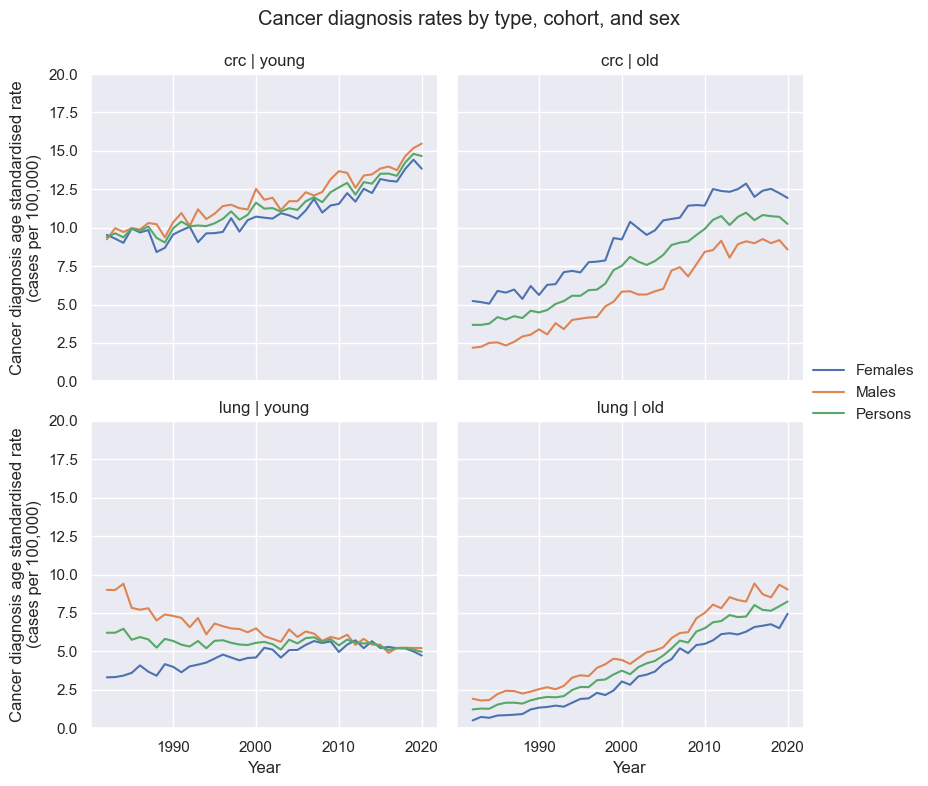

In [30]:
# Create facet grid: rows for cancer type, columns for cohort_x
g = sns.FacetGrid(
    df_final,
    row="cancer_type",
    col="cohort_x",
    height=4,
    aspect=1
)

# Map lineplots
g.map_dataframe(sns.lineplot, x="year", y="rate", hue="sex")

# Axis labels, titles, legend
g.set_axis_labels("Year", "Cancer diagnosis age standardised rate\n(cases per 100,000)")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()

# Set consistent y-limit across all facets
g.set(ylim=(0, 20))

# Overall title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Cancer diagnosis rates by type, cohort, and sex")

plt.show()

## Activity 4: translating the results back to clinical language

### Activity 4.1. What have you found?

Keeping in mind the original query "How is the incidence of colorectal cancer in Australia changing over time?", **describe your findings, including:**

- Which charts you think would best illustrate your response to the query
- Any caveats or assumptions that need to be communicated to avoid misunderstandings
- Any ways that the data has limited your ability to respond to the query**

## (Optional) Bonus Activity: Geospatial analysis of colorectal cancer rates

Let's look at how the incidence of colorectal cancer cases vary throughout Australia

In [28]:
import geopandas as gpd
import folium

In [77]:
gdf = gpd.read_file('data/SA2_2016_AUST.shp')

In [72]:
df_cancer_data = pd.read_excel('data/ACA 2 - Diagnosis change over time estimates.xlsx', 
                               sheet_name='Bowel cancer - invasive').query('Years == 2019')

In [73]:
gdf2 = (
    gdf
    .merge(df_cancer_data, left_on='SA2_NAME16', right_on='SA2 name')
    .loc[:, ['SA2 code', 'SA2 name', 'Years', 'Estimate - Persons', 'geometry']]
    .rename(columns={'SA2 code': 'sa2_code', 'SA2 name': 'sa2_name', 'Years': 'year', 'Estimate - Persons': 'relative risk'})
)

In [ ]:
# Create base map (centered on your data)
m = folium.Map(location=[-37.34,
                         143],
               zoom_start=8)

# Add choropleth
folium.Choropleth(
    geo_data=gdf2.to_json(),
    data=gdf2,
    columns=['sa2_code', 'relative risk'],
    key_on='feature.properties.sa2_code',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Value'
).add_to(m)

In [ ]:
m

## (Optional) Another Bonus Activity: Data transformation practice

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from easypandas import EasyDataFrame
from d2k_utils_2025 import get_month, get_year, get_day_of_week

sns.set()
%matplotlib inline

In [3]:
# fictitious blood test results
df = EasyDataFrame(data={'patientid': [1, 1, 1, 2, 2, 3, 3], 
                         'date': ['24-09-2013', '15-11-2013', '06-06-2014', '01-09-2016', '06-09-2016', '31-08-2000', '29-08-2001'], 
                         'blood_test_name': ['Haemoglobin', 'Haemoglobin', 'Platelets', 'Haemoglobin', 'Haemoglobin', 'Platelets', 'WCC'],
                         'blood_test_result': [154, 149, 226, 132, 139, 250, 6.2]})

# convert dates to datetime values
df = df.assign(date=lambda df_: pd.to_datetime(df_.date, dayfirst=True))

# patient postcode information
df2 = EasyDataFrame(data={'patientid': [1, 2, 3], 'postcode': [3000, 3078, 3056]})

In [4]:
df

,patientid,date,blood_test_name,blood_test_result
0,1,2013-09-24,Haemoglobin,154.0
1,1,2013-11-15,Haemoglobin,149.0
2,1,2014-06-06,Platelets,226.0
3,2,2016-09-01,Haemoglobin,132.0
4,2,2016-09-06,Haemoglobin,139.0
5,3,2000-08-31,Platelets,250.0
6,3,2001-08-29,WCC,6.2


In [5]:
df2

,patientid,postcode
0,1,3000
1,2,3078
2,3,3056


**Question 1: join the table of blood test results to the patient table**

In [8]:
df_new = df.join(df2, left_on='patientid', right_on='patientid', how='left')
df_new

,patientid,date,blood_test_name,blood_test_result,postcode
0,1,2013-09-24,Haemoglobin,154.0,3000
1,1,2013-11-15,Haemoglobin,149.0,3000
2,1,2014-06-06,Platelets,226.0,3000
3,2,2016-09-01,Haemoglobin,132.0,3078
4,2,2016-09-06,Haemoglobin,139.0,3078
5,3,2000-08-31,Platelets,250.0,3056
6,3,2001-08-29,WCC,6.2,3056


**Question 2: Get the maximum blood test result for each blood test, then sort from smallest to largest**

In [10]:
df_new.groupby('blood_test_name', 'blood_test_result', 'max').sort('blood_test_result')

,blood_test_name,blood_test_result
2,WCC,6.2
0,Haemoglobin,154.0
1,Platelets,250.0


**Question 3: Filter the data to haemoglobin results, then sort by patientid in reverse order**

In [20]:
df_new.filter('blood_test_name', 'equals', 'Haemoglobin').sort('patientid', ordering='descending')

,patientid,date,blood_test_name,blood_test_result,postcode
3,2,2016-09-01,Haemoglobin,132.0,3078
4,2,2016-09-06,Haemoglobin,139.0,3078
0,1,2013-09-24,Haemoglobin,154.0,3000
1,1,2013-11-15,Haemoglobin,149.0,3000


**Question 4: select the blood test name and result columns and then add a new column that labels the rows**

In [23]:
df_new.select(['blood_test_name', 'blood_test_result']).add_column('row_number', [1, 2, 3, 4, 5, 6, 7])

,blood_test_name,blood_test_result,row_number
0,Haemoglobin,154.0,1
1,Haemoglobin,149.0,2
2,Platelets,226.0,3
3,Haemoglobin,132.0,4
4,Haemoglobin,139.0,5
5,Platelets,250.0,6
6,WCC,6.2,7
